In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from torchtext.data.utils import get_tokenizer
from collections import Counter
import torchtext
from torchtext.vocab import Vocab,  build_vocab_from_iterator
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pad_sequence
!pip install -U spacy
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 51.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
file_path = '/content/eng_-french.csv'
try:
    data = pd.read_csv(file_path, on_bad_lines='skip')  # for pandas versions 1.3.0 and later
except Exception as e:
    print("An error occurred:", e)

print(data.columns)
print(len(data))

Index(['English words/sentences', 'French words/sentences'], dtype='object')
175621


In [ ]:
# Tokenization
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_fr = get_tokenizer('spacy', language='fr_core_news_sm')

def build_vocab(texts, tokenizer):
    token_generator = (tokenizer(text) for text in texts)
    return build_vocab_from_iterator(token_generator, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

vocab_en = build_vocab(data['English words/sentences'], tokenizer_en)
vocab_fr = build_vocab(data['French words/sentences'], tokenizer_fr)

train_df, temp_df = train_test_split(data, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


def data_process(df,vocab_en,vocab_fr,tokenizer_en,tokenizer_fr):
    data = []
    for idx, row in df.iterrows():
        raw_de = row['French words/sentences']
        raw_en = row['English words/sentences']

        de_tensor_ = torch.tensor([vocab_fr[token] for token in tokenizer_fr(raw_de.rstrip("\n"))], dtype=torch.long)
        en_tensor_ = torch.tensor([vocab_en[token] for token in tokenizer_en(raw_en.rstrip("\n"))], dtype=torch.long)

        data.append(( en_tensor_,de_tensor_))
    return data


BATCH_SIZE = 32
PAD_IDX = vocab_en['<pad>']
BOS_IDX = vocab_en['<bos>']
EOS_IDX = vocab_en['<eos>']

train_data = data_process(train_df,vocab_en,vocab_fr,tokenizer_en,tokenizer_fr)
val_data = data_process(val_df,vocab_en,vocab_fr,tokenizer_en,tokenizer_fr)
test_data = data_process(test_df,vocab_en,vocab_fr,tokenizer_en,tokenizer_fr)


# DataLoader
def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
shuffle=True, collate_fn=generate_batch)




# print("Total number of batches:", len(train_iter))

# # Loop over the DataLoader
# for idx, (src_batch, tgt_batch) in enumerate(train_iter):

#     if idx >= 5:  # Only process the first 5 batches
#         break
#     print(f"Batch {idx + 1}:")
#     print(f"  Source batch size (src_batch): {src_batch.size()}")
#     print(f"  Target batch size (tgt_batch): {tgt_batch.size()}")

#     # Uncomment the following lines if you want to see the actual data in the tensor
#     print("  Source Data:", src_batch)
#     print("  Target Data:", tgt_batch)
#     print("-" * 50)



In [ ]:
print("Total number of batches:", len(train_iter))


Total number of batches: 3842


Epoch 1, Train Loss: 3.3898, Valid Loss: 1.6578, Train Acc: 0.2487, Valid Acc: 0.3889
Epoch 2, Train Loss: 1.4885, Valid Loss: 1.4277, Train Acc: 0.4031, Valid Acc: 0.4103
Epoch 3, Train Loss: 1.3724, Valid Loss: 1.4019, Train Acc: 0.4130, Valid Acc: 0.4153
Epoch 4, Train Loss: 1.3604, Valid Loss: 1.3996, Train Acc: 0.4142, Valid Acc: 0.4140
Epoch 5, Train Loss: 1.3594, Valid Loss: 1.3996, Train Acc: 0.4137, Valid Acc: 0.4123
Epoch 6, Train Loss: 1.3590, Valid Loss: 1.3990, Train Acc: 0.4132, Valid Acc: 0.4138
Epoch 7, Train Loss: 1.3589, Valid Loss: 1.3996, Train Acc: 0.4133, Valid Acc: 0.4139
Epoch 8, Train Loss: 1.3587, Valid Loss: 1.4000, Train Acc: 0.4146, Valid Acc: 0.4136
Epoch 9, Train Loss: 1.3591, Valid Loss: 1.3994, Train Acc: 0.4144, Valid Acc: 0.4116
Epoch 10, Train Loss: 1.3588, Valid Loss: 1.3995, Train Acc: 0.4136, Valid Acc: 0.4140


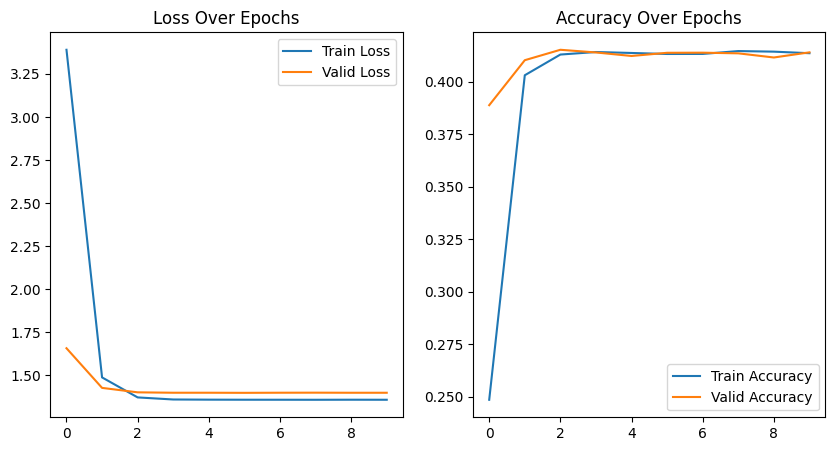

In [6]:
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].to(device)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        #query has shape [batch_size,seq_length,d_model]
        # Linear projections
        query = self.query(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        #splits into [batch_size, seq_length, num_heads,d_k]
        key = self.key(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        # input = batch_size X seq_len X d_model into batch_size X heads X seq_len X d_model/heads


        # Scaled Dot-Product Attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        #key matrix after transpose : [batch_size, num_heads, d_k, seq_len]

        #dimension of scores - [batch_size, num_heads, seq_len, seq_len]
        if mask is not None:
            scores = scores.masked_fill(mask == 1, float('-inf'))

        attention = F.softmax(scores, dim=-1)
        output = torch.matmul(attention, value)

        # Concatenate heads and put through final linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.out(output)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        # Multi-head attention
        src2 = self.multi_head_attention(src, src, src, src_mask)
        src = self.layer_norm1(src + src2)
        # Feed-forward
        src2 = self.feed_forward(src)
        src = self.layer_norm2(src + src2)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(DecoderLayer, self).__init__()
        self.multi_head_attention1 = MultiHeadAttention(d_model, num_heads)
        self.multi_head_attention2 = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, tgt_mask, memory_mask):
        # Masked multi-head attention (self-attention)
        tgt2 = self.multi_head_attention1(tgt, tgt, tgt, tgt_mask)
        tgt = self.layer_norm1(tgt + tgt2)
        # Multi-head attention over the output of the encoder stack
        tgt2 = self.multi_head_attention2(tgt, memory, memory, memory_mask)
        tgt = self.layer_norm2(tgt + tgt2)
        # Feed-forward
        tgt2 = self.feed_forward(tgt)
        tgt = self.layer_norm3(tgt + tgt2)
        return tgt

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=1, num_encoder_layers=3, num_decoder_layers=3, dropout=0.1):
        super(Transformer, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(p=dropout)

        self.encoders = nn.ModuleList([EncoderLayer(d_model, num_heads) for _ in range(num_encoder_layers)])
        self.decoders = nn.ModuleList([DecoderLayer(d_model, num_heads) for _ in range(num_decoder_layers)])

        self.out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        for encoder in self.encoders:
            src = encoder(src, src_mask)

        for decoder in self.decoders:
            tgt = decoder(tgt, src, tgt_mask, src_mask)

        return self.out(tgt)

def create_padding_mask(seq):
  # input dim of seq (batch_size, seq_len, dimension)
    seq = (seq == 1).float()
# updates the matrix to 1, if if is padded( i.e. the number it has is 1( we represent padding by 1))
    #creates a boolean mask, 1 for padding and 0 for non-padding
    return seq.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size,device):
    mask = torch.triu(torch.ones(size, size,device=device), diagonal=1)
    return mask  # (seq_len, seq_len)


transformer = Transformer(
    src_vocab_size=len(vocab_en),
    tgt_vocab_size=len(vocab_fr),
    d_model=512,
    num_heads=32,
    num_encoder_layers=3,
    num_decoder_layers=3
)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)

# Optimizer
optimizer = optim.Adam(transformer.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# Loss Function
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab_fr['<pad>'])

def calculate_accuracy(y_pred, y_true):
    y_pred = torch.argmax(F.log_softmax(y_pred, dim=1), dim=1)
    correct = (y_pred == y_true).float()
    acc = correct.sum() / len(correct)
    return acc


# Training Function
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    total_acc = 0
    total_loss = 0

    for src, tgt in data_loader:
        src, tgt = src.to(device), tgt.to(device)

        src = src.transpose(0, 1)  # Transpose to make [batch_size, seq_len]
        tgt = tgt.transpose(0, 1)
        tgt_input = tgt[:, :-1]
        # print("tgt_input",tgt_input.size())
        tgt_out = tgt[:, 1:]
        # print("tgt_out",tgt_out.size())
        # print("tgt_input_size(1),", tgt_input.size(1))
        src_mask = create_padding_mask(src).to(device)
        # print("src_mask", src_mask.size())
        # dimension of src_mask - [batch_size,1,1,seq_len]  -- bunch of ones and zeroes
        tgt_mask = (create_padding_mask(tgt_input) * create_look_ahead_mask(tgt_input.size(1),device))
        # print("tgt_mask", tgt_mask.size())
        # multiplication of [batch_size, 1, 1, seq_len]*[seq_len,seq_len]
        # tgt_mask is - [batch_size, 1, seq_len,seq_len] -- bunch of ones and zeroes
        optimizer.zero_grad()
        # Forward pass
        outputs = model(src, tgt_input, src_mask, tgt_mask)
        outputs = outputs.reshape(-1, outputs.shape[2])
        tgt_out = tgt_out.reshape(-1)
        # print(f"outputs:{outputs.size()},tgt_out:{tgt_out.size()}")
        # Calculate loss
        loss = loss_fn(outputs, tgt_out)
        acc = calculate_accuracy(outputs, tgt_out)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        total_acc += acc.item()

    return total_loss / len(data_loader), total_acc / len(data_loader)


def validate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_acc=0

    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)

            src = src.transpose(0, 1)
            tgt = tgt.transpose(0, 1)

            tgt_input = tgt[:, :-1]
            src_mask = create_padding_mask(src).to(device)
            tgt_mask = create_padding_mask(tgt_input) * create_look_ahead_mask(tgt_input.size(1),device)
            outputs = model(src, tgt_input, src_mask, tgt_mask)
            outputs = outputs.reshape(-1, outputs.shape[2])
            tgt_out = tgt[:, 1:].reshape(-1)
            loss = loss_fn(outputs, tgt_out)
            acc = calculate_accuracy(outputs, tgt_out)

            # print("loss")
            total_loss += loss.item()
            total_acc += acc.item()

    return total_loss / len(data_loader),  total_acc / len(data_loader)

num_epochs=10

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss,train_acc = train(transformer, train_iter, optimizer, loss_fn, device)
    val_loss,valid_acc = validate(transformer, test_iter, loss_fn, device)
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()


In [7]:
test_loss,test_acc = validate(transformer, val_iter, loss_fn, device)
print("test accuray:",test_acc," , test loss:",test_loss)

test accuray: 0.4154562129123697  , test loss: 1.3997986560452331
